## Chapter 3: First order methods

# A.2 Momentum-Accelerated Gradient Descent

In the previous Section we discussed a fundamental issue associated with the *direction* of the negative gradient: it can - depending on the function being minimized - oscillate rapidly, leading to zig-zagging gradient descent steps that slow down minimization.  In this Section we describe a popular enhancement to the standard gradient descent step, called *momentum accelerated gradient descent*, that is specifically designed to ameliorate this issue.  The core of this idea comes from the field of *time series analysis*, and in particular is a tool for smoothing time series known as the *exponential average*.  Here we first introduce the exponential average and then detail how it can be integrated into the standard gradient descent step in order to help ameliorate some of this zig-zagging (when it occurs) and consequently speeding up gradient descent.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from standard libraries and autograd
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
import autograd.numpy as np
from datetime import datetime 
import copy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

# demos for this notebook
static_plotter = optlib.static_plotter.Visualizer()
datapath = '../../mlrefined_datasets/superlearn_datasets/'

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# center all images in notebook and associated html
from IPython.display import HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
    width="400";
    height="400";
}
</style>
"""))

##  The exponential average

In the figure below we show an example of a *time series* dataset.  This particular example comes from a real snippet of a financial time series - a history of the price of a financial stock over 500 periods of time.  However time series datasets abound in science, engineering, and buisness (and are a subject of particular study in machine learning, as we discuss in a future Chapter).  More specifically, a time series dataset consists of a sequence of $K$ *ordered points* $w^1,\,w^2,\,...,w^K$.  Note: These points are assumed *ordered*, meaning that the point $w^1$ comes before (that is, it is created and / or collected before) $w^2$, the point $w^2$ before $w^3$, and so on.   For example we *generate* a time series of points whenever we run a local optimization scheme with steps

\begin{equation}
\mathbf{w}^k = \mathbf{w}^{k-1} + \alpha \mathbf{d}^{k-1}
\end{equation}


which produces the time series sequence of ordered points $\mathbf{w}^{1},\,\mathbf{w}^{2},\,...,\mathbf{w}^{K}$ that are potentially multi-dimensional.

In any case, because the raw values of a time series often oscillates or *zig-zags* up and down it is common practice to *smooth them* to remove these zig-zagging motions prior to further analysis.  The *exponential average* is one of the most popular such smoothing techniques for time series, and is used in virtually every application in which time series arise.  We show the result of smoothing the example time series below via the exponential average - with the resulting exponential average shown as a orange curve.  Note that the first average point - set to be the first point of the input series $x_1$ - is shown as a pink dot.

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# load in data
csvname = datapath + 'ford_data.csv'
data = pd.read_csv(csvname)
x = np.array(data['Close'])    # date: 1980 to 2017

# exponential average function
def exponential_average(x,alpha):
    h = [x[0]]
    for p in range(len(x) - 1):
        # get next element of input series
        x_p = x[p]
        
        # make next hidden state
        h_p = alpha*h[-1] + (1 - alpha)*x_p
        h.append(h_p)
    return np.array(h)

# produce moving average time series
alpha = 0.9
h = exponential_average(x,alpha)

# run animator
demo = optlib.exponential_average_animator.Visualizer()
demo.animate_exponential_ave(x,h,savepath='videos/animation_9.mp4')

from IPython.display import clear_output
clear_output()

In [3]:
## This code cell will not be shown in the HTML version of this notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_9.mp4" type="video/mp4">
  </video>
""")

Below we animate the same running average process as shown above for the same input series - but for only the first 50 points.

In [4]:
## This code cell will not be shown in the HTML version of this notebook
# run animator
demo = optlib.exponential_average_animator.Visualizer()
demo.animate_exponential_ave(x[:100],h[:100],savepath='videos/animation_10.mp4')

from IPython.display import clear_output
clear_output()

In [5]:
## This code cell will not be shown in the HTML version of this notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_10.mp4" type="video/mp4">
  </video>
""")

Before we see how the exponential average is computed lets first see how to compute a *running average* of $K$ input points $w^1,\,w^2,\,...,w^K$, that is the average of the first two points, the average of the first three points, and so forth.  Naively we could write down this running average as so

\begin{array}
\
\text{average of the first $1$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^1 = w^1 \\
\text{average of the first $2$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^2 = \frac{w^1 + w^2}{2} \\
\text{average of the first $3$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^3 = \frac{w^1 + w^2 + w^3}{3} \\
\text{average of the first $4$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^4 = \frac{w^1 + w^2 + w^3 + w^4}{4} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\text{average of the first $k$ elements:} \,\,\,\,\,\,\,\,\,\,\,\,\, h^{k} = \frac{w^1 + w^2 + w^3 + w^4 + \cdots  + w^k}{k} \\
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, \vdots \\
\end{array}

Notice how at each step here the average computation $h^t$ *summarizes* the input points $w^1$ through $w^k$ via a simple summary statistic: their sample mean.   However as written above, we *need every raw point $w^1$ through $w^k$* in order to compute the running average $h^k$.

Fortunately we can write this running average more effeciently by studying the form of each computation.  For example notice how the average of $x^1$ and $x^2$ can be written as

\begin{equation}
h^2 = \frac{w^1 + w^2}{2} = \frac{h^1 + w^2}{2} = \frac{1}{2}h^1 + \frac{1}{2}w^2.
\end{equation}

Likeiwse, looking at the next line we can write $h^4$ in terms of its predecessor $h^3$ as 

\begin{equation}
h^3 = \frac{w^1 + w^2 + w^3}{3} = \frac{2\frac{w^1 + w^2}{2} + w^3}{3} = \frac{2h^2 + w^3}{3} = \frac{2}{3}h^2 + \frac{1}{3}w^3.
\end{equation}

In general we can express the $k^{th}$ running average $h^{k}$ for $k > 1$ in the same sort of way, involving only its preceeding running average and raw time series value as

\begin{equation}
h^{k} = \frac{k-1}{k}h^{t-1} + \frac{1}{k}w^k.
\end{equation}

What is the benefit of writing the *running average* in this way, as opposed to the naive way given above?  Imagine we computed the running average one update at a time from $h^1$ all the way to $h^k$.  When compared to the naive way of computing the average

\begin{equation}
h^{k} = \frac{w^1 + w^2 + w^3 + w^4 + \cdots + w^k}{k}
\end{equation}

here we need to know (i.e., store) the explicit values of every value up to and including $w^k$ (that is $w^1$ through $w^{k}$), whereas with the clever way of writing the same average above we only need to access two values: $w^k$ and $h^{k-1}$.  From a computational perspective, this is far more memory effecient (since at each step we only need to store and deal with two values as opposed to $t$ of them).  

The *exponential average* is a simple generalization of this running average formula.  Notice that at every step in the clever recursion in equation for the running average in (3) that the coeffecients on the two terms in the update *always sum to $1$*: that is $\frac{k-1}{k} + \frac{1}{k} = 1$ for all $k$ always.  At each step both coeffecients change as $\frac{k-1}{k}$ and $\frac{1}{k}$ respectively, and the to create the exponential average we use the same update formula but *freeze the coeffecients*.  That is, using the same initial value $h^1 = w^1$ and for $k > 1$ we take a value $\beta \in \left[0,1\right]$ and create a running *exponential average* via the similar formula

\begin{equation}
h^{k} = \beta \, h^{k-1} +  \left(1 - \beta\right)w^k.
\end{equation}

Clearly the parameter $\beta$ here controls a tradeoff: the smaller we set $\beta$ the more our exponential average approximates the raw (zig-zagging) time series itself, while the larger we set it the more each subsequent average looks like its predecessor.  However regardless of how we set $\beta$ each step $h^k$ in an exponential average - like the running average - summarizes *every point in the time series that preceeds it* $w^1,\,w^2,\,...,w^{k}$.

>  Each step $h^k$ in an exponential average - like the running average - summarizes *every point in the time series that preceeds it*: $w^1,\,w^2,\,...,w^{k}$

Why is this slightly adjusted version of the running average called an *exponential average*?  Because if we 'roll back' the update shown above back - expressing each update step $h^k$ in terms of all its preceeding elements - we can see the exponential relationship explicitly.  We show this algebraic manipulation below.  Needless to say with this update - as with the running average - *each and every step $h^k$ summarizes the elements of the input that preceeds it* ($w^1$ through $w^k$) via an (exponential) average.

By using the exponential averaging formula above - and substituting in the value of each preceeding value $h^{k-1}$, all the way back to $h^1$ - we can 'roll back' the exponential average at each step so that $h^k$ is expressed entirely in terms of the input values $w^1$ through $w^k$ preceeding it.  For example, substituting in the same formula for $h^{k-1} = \beta \, h^{k-2} +  \left(1 - \beta\right)w^{k-1}$ into the right hand side above for $h^k$ gives after simplifying

\begin{equation}
h^k = \beta \, h^{k-1} +  \left(1 - \beta\right)w^k = \beta\left(\beta\, h^{k-2} + \left(1 - \beta\right)w^{k-1}\right) + \left(1 - \beta\right) w^k = 
\left(\beta\right)^2 \, h^{k-2} + \beta  \left(1 - \beta\right)w^{k-1} + \left(1 - \beta\right) w^k.
\end{equation}

Note here that the notation $\left(\beta\right)^2$ means *raise the constant $\beta$ to the second power* i.e., $\beta = \beta \times \beta$, whereas our typical superscript notation $h^{k-1}$ and $w^{k-1}$ still denotes the $\left(k-1\right)^{th}$ element of each of these sequences respectively.

If we continue doing this we can 'roll back' all the way to the initial condition - which expresses our step $h^k$ in terms of *every input sequence value $w^1$ through $w^k$* as 

\begin{equation}
h^{k} = \left(\beta\right)^{\,k} \, w^1 + \left(\beta\right)^{\,k-1}\,\left(1 - \beta\right) w^{2} + \left(\beta\right)^{\,k-2}\left(1 - \beta\right)w^3 + \cdots  + \beta\,\left(1 - \beta\right)w^{k-1}  + \left(1 - \beta\right)w^k 
\end{equation}

Aain note here that the notation $\left(\beta\right)^k$ means *raise the constant $\beta$ to the $k^{th}$ power* whereas our typical superscript notation $h^{k-1}$ and $w^{k-1}$ still denotes the $\left(k-1\right)^{th}$ element of each of these sequences respectively.

Also note: by unwravelling the definition of $h^k$ we can indeed see that it is a function (an average) of *every point of the time series that preceeds it*: $w^1,\,w^2,\,...,w^{k}$.

Of course just as with the running average we prefer our simple update step for the exponential average

\begin{equation}
h^{k} = \beta \, h^{k-1} +  \left(1 - \beta\right)w^k
\end{equation}

over such a long list of formulae, as it is far more effecient (requiring only two values per update compared with $k$). 

Lastly, note that in deriving the exponential average we assumed our time series was *one-dimensional*, that is each raw point $w^k$ has only a single dimension.  However this idea holds for time series *irregardless of their input dimension* (like the steps of a local optimization run).  We can likewise define the exponential average of a time series of general $N$ dimensional points $\mathbf{w}^1,\,\mathbf{w}^2,\,...,\mathbf{w}^K$ by initializing $\mathbf{h}^1 = \mathbf{w}^1$ and then for $k > 1$ building $\mathbf{h}^k$ as 

\begin{equation}
\mathbf{h}^{k} = \beta \, \mathbf{h}^{k-1} +  \left(1 - \beta\right)\mathbf{w}^k.
\end{equation}

Here the exponential average at step $k$ $\mathbf{h}^k$ is also $N$ dimensional.

##  Ameliorating the zig-zag behavior of gradient descent 

In the previous Section we saw how our gradient descent scheme

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)
\end{equation}

naturally suffers from zig-zagging behavior that slows progress of minimization.  Notice that, in the context of our discussion above regarding the exponential average, both our sequence of gradient descent steps (or any local optimization scheme for that matter) *and* the negative gradient directions themselves are both *time series*.  Indeed if we take $K$ steps of gradient descent using the form above we do create an time series of ordered *gradient descent steps* $\mathbf{w}^1,\,\mathbf{w}^{1},\,...,\mathbf{w}^{K}$ and descent directinos $-\nabla g\left(\mathbf{w}^{0}\right),\,-\nabla g\left(\mathbf{w}^{1}\right),...,-\nabla g\left(\mathbf{w}^{K-1}\right)$.  In the context of local optimization we use the index $k$ instead of $t$, but besides this slight notational difference these are indeed time series.

To attempt to ameliorate some of the zig-zagging behavior of our gradient descent steps  $\mathbf{w}^1,\,\mathbf{w}^{1},\,...,\mathbf{w}^{K}$ we could compute their *exponential average*, as this will surely smooth them out much as they did in the example used to introduce the exponential average above.  However we do not want to smooth the gradient descent steps *after* they have been created - the 'damage is already done' in the sense that the zig-zagging has already slowed the progress of a gradient descent run.  Instead what we want is to smooth the steps *as they are created*, so that our algorithm makes more progress in minimization.

How do we smooth the steps as the are made?  Remember from the previous Section that the root cause of zig-zagging gradient descent steps zig-zag is the oscillating nature of the (negative) gradient directions themselves.  In other words, if the descent directions $-\nabla g\left(\mathbf{w}^{0}\right),\,-\nabla g\left(\mathbf{w}^{1}\right),...,-\nabla g\left(\mathbf{w}^{K-1}\right)$ zig-zag, so to will the gradient descent steps.  So it seems reasonable to suppose that if we smooth out these directions as they are created during a run of local optimization we can - as a consequence - produce steps that do not zig-zag as much and therefore make more progress in minimization.

Using the exponential average explained earlier in this Section, we will to create our smoothed descent directions as they are created.  We initialize $\mathbf{d}^0 = \nabla g\left(\mathbf{w}^0\right)$ and then for $k -1 > 0$ the $\left(k-1\right)^{th}$ exponentially averaged descent direction $\mathbf{d}^{k-1}$ takes the form (by the very definition of the exponentially average given previously) 

\begin{equation}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2} -  \left(1 - \beta\right)\nabla g\left(\mathbf{w}^{k-1}\right)
\end{equation}


We can then use this descent direction in our generic local optimization framework to step as

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \, \mathbf{d}^{k-1}.
\end{equation}

Together this exponential averaging adds only a single step to our gradient descent scheme - which together are

\begin{equation}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2}  - \left(1 - \beta\right)\nabla g\left(\mathbf{w}^{k-1}\right) \\
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \, \mathbf{d}^{k-1}. \,\,\,\,\,\,\,\,\,\,\,\,\,     \,\,\,\,\,\,\,\,\,\,\,\,\,      \,\,\,
\end{equation}

Nonetheless since this simple adjustment was explicitly designed to help ameliorate the zig-zagging problem that can occur with standard gradient descent it can be substantially more effective.  This simple adjustment to gradient descent is often called *momentum acclerated gradient descent*.  The term 'momentum' here refers to the new exponentially averaged descent direction $\mathbf{d}^{k-1}$.  Notice that by the very definition of the exponential gradient given in the first part of this Section, that this descent direction $\mathbf{d}^{k-1}$ is a function (an exponential average) of *every negative gradient which preceeds it* $-\nabla g\left(\mathbf{w}^{0}\right),\,-\nabla g\left(\mathbf{w}^{1}\right),...,-\nabla g\left(\mathbf{w}^{k-1}\right)$

> The descent direction used in accelerated gradient descent is an exponential average, meaning that $\mathbf{d}^{k-1}$ is an exponential average of every negative gradient direction preceeding it $-\nabla g\left(\mathbf{w}^{0}\right),\,-\nabla g\left(\mathbf{w}^{1}\right),...,-\nabla g\left(\mathbf{w}^{k-1}\right)$

As with any exponential average the choice of $\beta \in \left[0,1\right]$ provides a trade-off between here.  The smaller $\beta$ is chosen the *more* the exponential average resembles the actual sequence of negative descent directions since *more* of each negative gradient direction is used in the update, but the *less* these descent directions summarize all of the previously seen negative gradients.  The larger $\beta$ is chosen the *less* these exponentially averaged descent steps resemble the negative gradient directions, since each update will use *less* of each subsequent negative gradient direction, but the *more* they represent a summary of them.  Often in practice larger values of $\beta$ are used, in the range $\left[0.7,1\right]$, meaning that often in practice a strongly summarizing descent direction $\mathbf{d}^{k-1}$ tends to provide better performance.

Note in practice this step is also written slightly differently than above, although this notational re-arrangement ammounts to exactly the same thing: instead of averaging the *negative* gradient directions the gradient itself is exponentially averaged, and then the *step* is taken in their *negative* direction.  This means that we initialize our exponential average at the first *negative* descent direction $\mathbf{d}^0 = -\nabla g\left(\mathbf{w}^0\right)$ and for $k-1 > 0$ the general descent direction and corresponding step is computed as

\begin{equation}
\mathbf{d}^{k-1} = \beta \, \mathbf{d}^{k-2} +  \left(1 - \beta\right)\nabla g\left(\mathbf{w}^{k-1}\right) \\
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \, \mathbf{d}^{k-1}. \,\,\,\,\,\,\,\,\,\,\,\,\,     \,\,\,\,\,\,\,\,\,\,\,\,\,      \,\,\,
\end{equation}

#### <span style="color:#a50e3e;">Example 1. </span>  Gradient descent directions on the contour plot of a quadratic function

In this example we compare a run of standard gradient descent to the *momentum accelerated* version detailed above using the first quadratic from Example 4 of the previous Section.  This pure quadratic has zero constant and linear terms and a matrix $\mathbf{C} = \begin{bmatrix} 0.5\,\,0 \\ 0 \,\, 12\end{bmatrix}$, and has a global minimum at the origin $\mathbf{w}=\begin{bmatrix} 0 \\ 0 \end{bmatrix}$.  Here we re-produce the same run of $25$ gradient descent steps shown in this prior example, and also compare two run of *momentum accelerated graient descent* with two choices for $\beta \in \{0.2, 0.7\}$.  All three runs are initialized at the same point $\mathbf{w}^0 = \begin{bmatrix} 10 \\ 1 \end{bmatrix}$ and use the same learning rate $\alpha = 10^{-1}$. 

We show the resulting steps taken by the standard gradient descent run in the top panel (where significant zig-zagging is present), and the momentum accelerated versions using $\beta = 0.2$ and $\beta = 0.7$ in the middle and bottom panels respectively.   Both momentum accelerated versions outperform the standard scheme, in that they reach a point closer to the true minimum of the quadratic, and clearly zig-zagging is significantly reduced in both momentum accelerated runs.   The choice of $\beta = 0.7$ provides better performance because it reduces zig-zagging while maintaining larger steplength - since its stronger summarizing descent direction maintains a larger magnitude (from the first steps of the run which are far from the minimum where the magnitude of the negative gradient was large) as the run approaches the minimum of the quadratic.  The case where $\beta = 0.2$, which is closer to the original negative gradient, starts taking smaller steps as it approaches the minimum since its descent direction more closely resembles the true negative gradient (whose magnitude is diminishing rapidly).

In [6]:
# This code cell will not be shown in the HTML version of this notebook
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def momentum(g,alpha_choice,beta,max_its,w):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    cost_eval,grad_eval = gradient(w)
    
    # initialization for momentum direction
    h = np.zeros((w.shape))
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)
        
        #### momentum step - update exponential average of gradient directions to ameliorate zig-zagging ###
        h = beta*h - (1 - beta)*grad_eval

        # take gradient descent step
        w = w + alpha*h
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

<IPython.core.display.Javascript object>


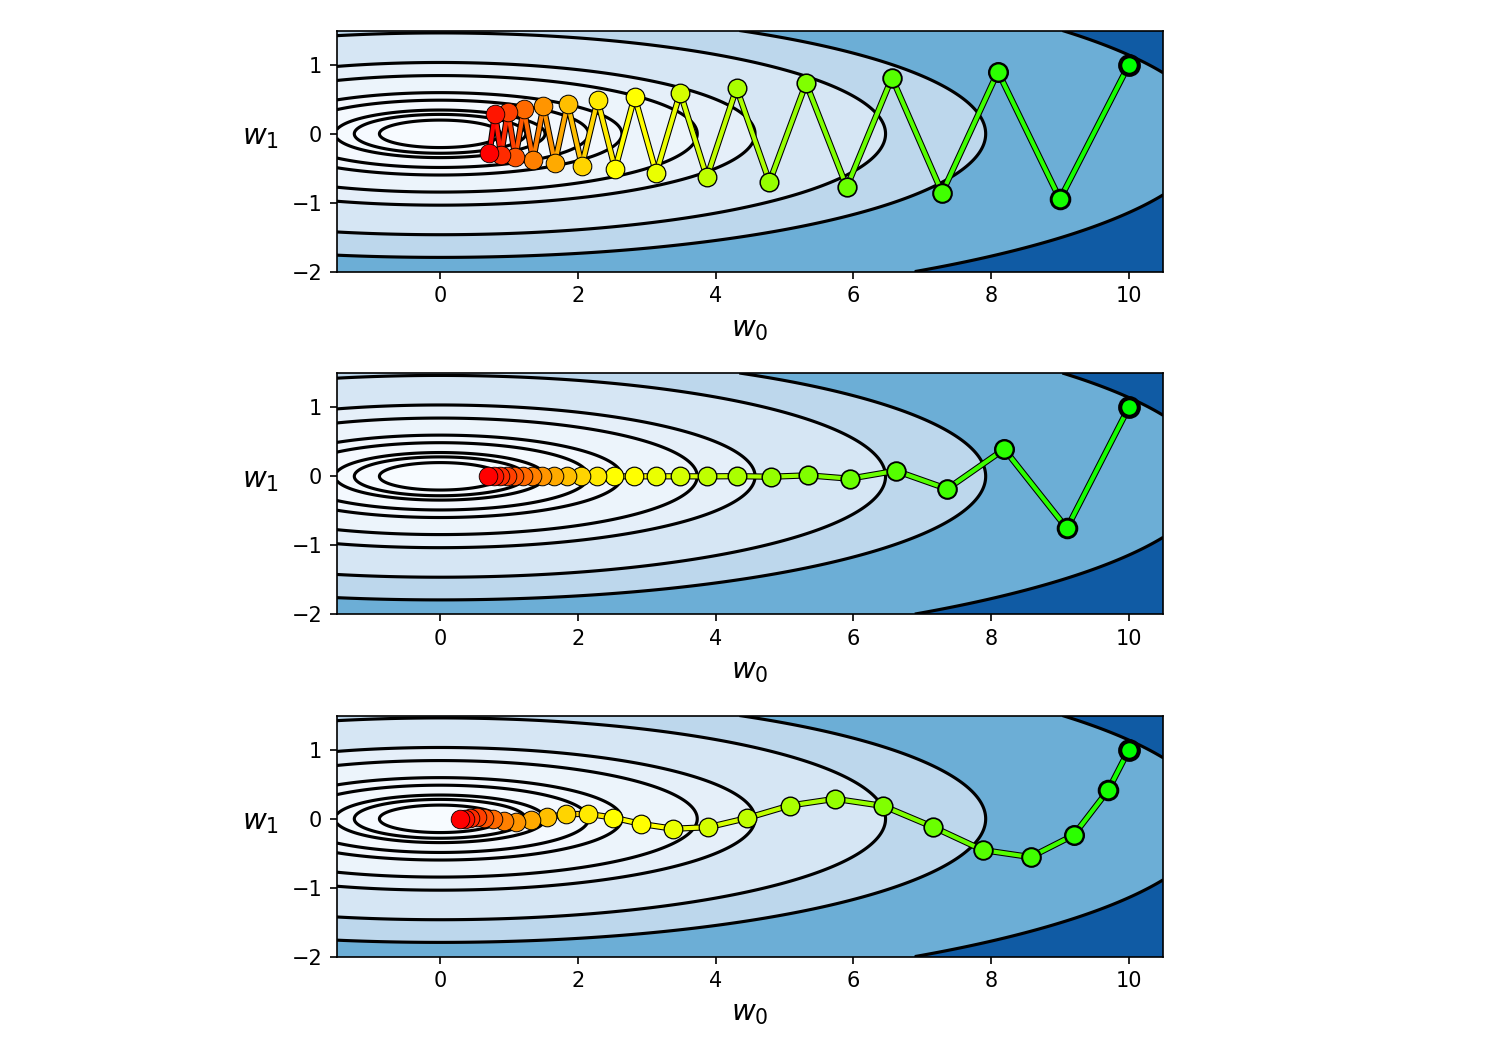

In [7]:
## This code cell will not be shown in the HTML version of this notebook
# define constants for a N=2 input quadratic
a1 = 0
b1 = 0*np.ones((2,1))
C1 = np.array([[0.5,0],[0,9.75]])

# a quadratic function defined using the constants above
g = lambda w: (a1 + np.dot(b1.T,w) + np.dot(np.dot(w.T,C1),w))[0]

w = np.array([10.0,1.0]); max_its = 25; alpha_choice = 10**(-1);
beta = 0
weight_history_1,cost_history_1 = momentum(g,alpha_choice,beta,max_its,w)

beta = 0.1;
weight_history_2,cost_history_2 = momentum(g,alpha_choice,beta,max_its,w)

beta = 0.7
weight_history_3,cost_history_3 = momentum(g,alpha_choice,beta,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
histories = [weight_history_1,weight_history_2,weight_history_3]
gs = [g,g,g]
static_plotter.two_input_contour_vert_plots(gs,histories,num_contours = 25,xmin = -1.5,xmax = 10.5,ymin = -2.0,ymax = 1.5)